Implementation fo neural machine translation with attention mechanism.
Ref: [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v2)

## Imports

In [1]:
# %config Completer.use_jedi=False

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader, Dataset

In [3]:
import gc
import numpy as np
import pandas as pd
import time
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

In [4]:
pd.options.display.width = 1200
pd.options.display.max_colwidth = 1000

In [5]:
from itertools import chain
from collections import Counter,OrderedDict
import re
import string
import time
import os
from datetime import datetime

In [6]:
# random seeds
SEED = 42
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [7]:
from torch.utils.tensorboard import SummaryWriter

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device.type.upper()} device')

Using CUDA device


# Data 

In [9]:
train_data, valid_data, test_data = torchtext.datasets.Multi30k()

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:04<00:00, 300kB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 92.5kB/s]
mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 88.0kB/s]


In [10]:
dataset_train = torchtext.data.to_map_style_dataset(train_data)
dataset_test = torchtext.data.to_map_style_dataset(test_data)
dataset_valid = torchtext.data.to_map_style_dataset(valid_data)

In [11]:
from spacy.lang.en import English
from spacy.lang.de import German

In [12]:
SRC = 'German'
TRG = 'English'
FILE_SUFFIX = 'en-de'
SRC_LANG = 'de'
TRG_LANG = 'en'

In [13]:
nlp_trg = English()
nlp_src = German()

In [14]:
def tokenizer_trg(text):
    return [token.text for token in nlp_trg.tokenizer(text.strip())]
def tokenizer_src(text):
    return [token.text for token in nlp_src.tokenizer(text.strip())] 

In [15]:
src_train_tokens = []
trg_train_tokens = []
for a, b in dataset_train:
    src_train_tokens.append(tokenizer_src(a))
    trg_train_tokens.append(tokenizer_trg(b))

In [16]:
src_train_tokens = list(chain.from_iterable(src_train_tokens))
trg_train_tokens = list(chain.from_iterable(trg_train_tokens))

In [17]:
# Fix bug in torchtext.vocab.build_vocab_from_iterator
def build_vocab_from_iterator_N(iterator, min_freq = 1, specials = None, special_first = True):
    """
    Build a Vocab from an iterator.

    Args:
        iterator: Iterator used to build Vocab. Must yield list or iterator of tokens.
        min_freq: The minimum frequency needed to include a token in the vocabulary.
        specials: Special symbols to add. The order of supplied tokens will be preserved.
        special_first: Indicates whether to insert symbols at the beginning or at the end.


    Returns:
        torchtext.vocab.Vocab: A `Vocab` object

    Examples:
        >>> #generating vocab from text file
        >>> import io
        >>> from torchtext.vocab import build_vocab_from_iterator
        >>> def yield_tokens(file_path):
        >>>     with io.open(file_path, encoding = 'utf-8') as f:
        >>>         for line in f:
        >>>             yield line.strip().split()
        >>> vocab = build_vocab_from_iterator(yield_tokens_batch(file_path), specials=["<unk>"])
    """

    counter = Counter()
    for tokens in iterator:
        counter.update([tokens]) # Added brackets. otherwise characters will be updated insted of words

    if specials is not None:
        for tok in specials:
            del counter[tok]

    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[0])
    sorted_by_freq_tuples.sort(key=lambda x: x[1], reverse=True)
    ordered_dict = OrderedDict(sorted_by_freq_tuples)

    if specials is not None:
        if special_first:
            specials = specials[::-1]
        for symbol in specials:
            ordered_dict.update({symbol: min_freq})
            ordered_dict.move_to_end(symbol, last=not special_first)

    word_vocab = torchtext.vocab.vocab(ordered_dict, min_freq=min_freq)
    return word_vocab

In [18]:
MIN_FREQ = 2
vocab_src = build_vocab_from_iterator_N(src_train_tokens, min_freq=MIN_FREQ, specials=['<pad>','<unk>', '<bos>', '<eos>'], special_first=True)
vocab_trg = build_vocab_from_iterator_N(trg_train_tokens, min_freq=MIN_FREQ, specials=['<pad>','<unk>', '<bos>', '<eos>'], special_first=True)

In [19]:
vocab_src.set_default_index(vocab_src['<unk>'])
vocab_trg.set_default_index(vocab_trg['<unk>'])

In [20]:
len(vocab_src), len(vocab_trg)

(8014, 6191)

In [21]:
tokenizer_src(dataset_train[0][0])

['Zwei',
 'junge',
 'weiße',
 'Männer',
 'sind',
 'im',
 'Freien',
 'in',
 'der',
 'Nähe',
 'vieler',
 'Büsche',
 '.']

In [22]:
# Function to perform padding

# pad_indx = vocab_src.word2indx['<pad>']
pad_indx = vocab_src['<pad>']

def collate_by_padding(batch):
    inputs = [None]*len(batch)
    targets = [None]*len(batch)
    inputs_len = [None]*len(batch)
    targets_len = [None]*len(batch)

    for i,(inp, targ) in enumerate(tuple(batch)):
        inp = vocab_src(tokenizer_src(inp)+['<eos>'])
        targ = vocab_trg(tokenizer_trg(targ)+['<eos>'])
        inputs[i] = torch.IntTensor(inp)
        targets[i] = torch.IntTensor(targ)
        
        inputs_len[i] = len(inp)
        targets_len[i] = len(targ)
        

    max_length_inputs = max(inputs_len)
    max_length_targets = max(targets_len)
    
    for i in range(len(batch)):
        inputs[i] = torch.cat((inputs[i], torch.IntTensor([pad_indx]*(max_length_inputs - inputs_len[i]))), dim=-1)
        targets[i] = torch.cat((targets[i], torch.IntTensor([pad_indx]*(max_length_targets - targets_len[i]))), dim=-1)
        
    return torch.stack(inputs), torch.stack(targets)
    

In [23]:
BATCH_SIZE = 128
SHUFFLE = True
DROP_LAST = True
dataloader_train  = torch.utils.data.DataLoader(dataset_train, shuffle=SHUFFLE, batch_size=BATCH_SIZE, drop_last=DROP_LAST, collate_fn=collate_by_padding)
dataloader_train_e  = torch.utils.data.DataLoader(dataset_train, shuffle=SHUFFLE, batch_size=BATCH_SIZE, drop_last=DROP_LAST, collate_fn=collate_by_padding)
dataloader_valid  = torch.utils.data.DataLoader(dataset_valid, shuffle=SHUFFLE, batch_size=BATCH_SIZE, drop_last=DROP_LAST, collate_fn=collate_by_padding)
dataloader_test  = torch.utils.data.DataLoader(dataset_test, shuffle=SHUFFLE, batch_size=len(dataset_test), drop_last=DROP_LAST, collate_fn=collate_by_padding)

In [24]:
len(dataloader_train), len(dataloader_valid), len(dataloader_test)

(226, 7, 1)

In [25]:
len(vocab_src), len(vocab_trg)

(8014, 6191)

# Model

In [26]:
class EncoderBlock(nn.Module):
    def __init__(self, vocab_size_in, embedding_size, n_hidden, n_layers,dropout_fraction):
        super(EncoderBlock, self).__init__()
        self.embedding = nn.Embedding(vocab_size_in, embedding_size, padding_idx=pad_indx, scale_grad_by_freq=True)
#         self.rnn = nn.LSTM(embedding_size, n_hidden, n_layers, batch_first=True,bidirectional=False, dropout=dropout_fraction)
        self.rnn = nn.GRU(embedding_size, n_hidden, n_layers, batch_first=True,bidirectional=False, dropout=dropout_fraction)
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
    def forward(self, inputs, hidden=None): # inputs: B x T_x
        emb1 = self.embedding(inputs) # emb1: B x T_x x E
        outputs, hidden = self.rnn(emb1, hidden)   # outputs: B x T_x x H_E*2 hidden: 1 x B x H_E*2
#         outputs = outputs[:,:,:self.n_hidden]+  outputs[:,:,self.n_hidden:]
        return  outputs, hidden #[self.n_layers:,:,:]

In [27]:
class AttentionBlock(nn.Module):
    def __init__(self, n_hidden):
        super(AttentionBlock, self).__init__()
        self.linear = nn.Linear(n_hidden, n_hidden, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.n_hidden_sqrt_inv = n_hidden**(-0.5)
        
    def forward(self, decoder_hidden, encoder_hidden_states, mask):
#         decoder_hidden_rep = decoder_hidden.expand(-1, encoder_hidden_states.shape[1], -1) # B x T_x x H_D
        scores = torch.bmm(decoder_hidden, self.linear(encoder_hidden_states).transpose(1,2))
        
        scores = mask*scores.squeeze(1)
        scores[scores==0] = -1e10 # ignoring pad indices
        
        attention_weights = self.softmax(scores.squeeze(1)*self.n_hidden_sqrt_inv)        
        
        return attention_weights

In [28]:
class DecoderAttentionBlock(nn.Module):
    def __init__(self, vocab_size_out, embedding_size, n_hidden, n_layers,dropout_fraction):
        super(DecoderAttentionBlock, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size_out, embedding_size, padding_idx=pad_indx, scale_grad_by_freq=True)
        self.attention = AttentionBlock(n_hidden)
        self.tanh = nn.Tanh()
#         self.rnn = nn.LSTM(embedding_size + n_hidden, n_hidden, n_layers, batch_first=True, dropout = dropout_fraction)
        self.rnn = nn.GRU(embedding_size, n_hidden, n_layers, batch_first=True, dropout = dropout_fraction)
        
        self.linear = nn.Linear(n_hidden*2, n_hidden*2, bias=False)
        self.fc = nn.Linear(n_hidden*2, vocab_size_out)
        
        self.lsf = nn.LogSoftmax(dim=-1)

    def forward(self, inputs, hidden, enc_hidden_seq, mask): # inputs: B x 1,  hidden: 1 x B x E_D , enc_hidden_seq: B x T_x x H_E*2
        
        emb1 = self.embedding(inputs) # emb1: B x 1 x E (only one token is input.. the previous output)
        outputs, hidden = self.rnn(emb1, hidden)
        
        attention_weights = self.attention(outputs,enc_hidden_seq, mask) # B x T_x x H_E
        
        context_vectors = attention_weights.unsqueeze(1).bmm(enc_hidden_seq) # B x H_E x H_D
        attention_vector = self.tanh(self.linear(torch.cat((context_vectors, outputs), dim=-1)))
#         outputs = self.fc(attention_vector).squeeze(1)
        outputs = self.lsf(self.fc(attention_vector).squeeze(1))
        # outputs = self.fc(outputs) # use CrossEntropyLoss
        
        return outputs, hidden, attention_weights 

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size_in, vocab_size_out,embedding_size, n_hidden, n_layers_enc, n_layers_dec, dropout_fraction,teacher_forcing_fraction=1.0):
        super(Seq2Seq, self).__init__()        
        self.encoder = EncoderBlock(vocab_size_in, embedding_size, n_hidden, n_layers_enc,dropout_fraction)
#         self.decoder = DecoderAttentionBlock(vocab_size_out, embedding_size, n_hidden, n_layers_dec,dropout_fraction)
        self.decoder = DecoderAttentionBlock(vocab_size_out, embedding_size, n_hidden, n_layers_dec,dropout_fraction)
        self.vocab_size_out = vocab_size_out
        self.teacher_forcing_fraction = teacher_forcing_fraction
        self.n_layers_dec = n_layers_dec
                    
        
    def forward(self, inputs, outputs, teacher_forcing_fraction=None):
        
        if teacher_forcing_fraction is None:
            teacher_forcing_fraction = self.teacher_forcing_fraction
        
#         mask = ((inputs.detach()!=0 )*(inputs.detach()!=3) ).long()
        mask = ((inputs.detach()!=0 ) ).long()
        
        encoder_outputs, hidden = self.encoder(inputs)
        
        start_token = torch.IntTensor([vocab_trg['<sos>']]).expand((inputs.shape[0],1)).to(inputs.device)
        decoder_hidden = hidden
#         decoder_hidden = None
        predictions = torch.zeros((outputs.shape[0],outputs.shape[1], self.vocab_size_out), device=inputs.device)
        teacher_targets = outputs.narrow(1, 0, outputs.size(1) - 1)
        
        decoder_input = start_token
        
        attention_list = []
        
        for i in range(outputs.shape[1]):
            
            out, decoder_hidden, decoder_attn = self.decoder(decoder_input, decoder_hidden, encoder_outputs, mask)
            predictions[:,i,:] = out.squeeze(1)
            if torch.rand(1).item() < teacher_forcing_fraction:
                decoder_input = outputs[:,i].unsqueeze(1)
            else:
                decoder_input = out.unsqueeze(1).argmax( dim=-1).detach()
            attention_list.append(decoder_attn.unsqueeze(2))
            
        return predictions, torch.cat(tuple(attention_list), dim=2)

In [30]:
VOCAB_SIZE_SRC = len(vocab_src)
VOCAB_SIZE_TRG = len(vocab_trg)
EMBEDDING_SIZE = 512
NUM_HIDDEN_UNITS = 512
NUM_RNN_LAYERS_ENC = 4
NUM_RNN_LAYERS_DEC = 4
DROPOUT_FRACTION = 0
TEACHER_FORCING_FRACTION = 0.8

In [31]:
suffix = '_'.join([SRC, TRG]) 
suffix

'German_English'

In [32]:
model = Seq2Seq(VOCAB_SIZE_SRC, VOCAB_SIZE_TRG, EMBEDDING_SIZE,NUM_HIDDEN_UNITS, NUM_RNN_LAYERS_ENC, NUM_RNN_LAYERS_DEC, DROPOUT_FRACTION,teacher_forcing_fraction=TEACHER_FORCING_FRACTION)
print(f'The model has {sum([torch.numel(par) for par in model.parameters()])/10**6}M trainable paraeters')

The model has 27.536943M trainable paraeters


In [33]:
model

Seq2Seq(
  (encoder): EncoderBlock(
    (embedding): Embedding(8014, 512, padding_idx=0, scale_grad_by_freq=True)
    (rnn): GRU(512, 512, num_layers=4, batch_first=True)
  )
  (decoder): DecoderAttentionBlock(
    (embedding): Embedding(6191, 512, padding_idx=0, scale_grad_by_freq=True)
    (attention): AttentionBlock(
      (linear): Linear(in_features=512, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
    )
    (tanh): Tanh()
    (rnn): GRU(512, 512, num_layers=4, batch_first=True)
    (linear): Linear(in_features=1024, out_features=1024, bias=False)
    (fc): Linear(in_features=1024, out_features=6191, bias=True)
    (lsf): LogSoftmax(dim=-1)
  )
)

In [34]:
# loss_function = nn.CrossEntropyLoss( reduction='mean', ignore_index=pad_indx)    
loss_function = nn.NLLLoss(ignore_index=pad_indx)

In [35]:

gc.collect()
torch.cuda.empty_cache()

In [36]:
v_t = vocab_trg.get_itos()
v_s = vocab_src.get_itos()

In [37]:
valid_losses_list = []
losses_list=[]

In [38]:
def eval(dataloader_valid):
    # Eval on validation data
    model.eval()
    loss_val = 0
    
    with torch.no_grad():
        pred_sentences = []
        true_pred_sentences = []
        for batch, a in enumerate(dataloader_valid):
            inputs = a[0]
            targets = a[1]
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute predictions
            pred,_ = model(inputs, targets, teacher_forcing_fraction=0)
            
            for row in targets:
                true_pred_sentences.append([[v_t[token]  for token in row.tolist() if token is not pad_indx]])
            
            for row in torch.argmax(pred, dim=-1):
                pred_sentences.append([v_t[token]  for token in row.tolist() if token is not pad_indx])
            
            # compute loss
            loss = loss_function(pred.view(-1,pred.shape[-1]), targets.long().view(-1))

            # loss
            loss_val += loss.item()

        loss_val = loss_val/len(dataloader_valid)
    try:
        bleu_score = torchtext.data.metrics.bleu_score(pred_sentences,true_pred_sentences)
    except:
        bleu_score = 0.0
    model.train()
    return loss_val, bleu_score

In [39]:
CLIP_NORM = 10

In [40]:
# Find optimal Learning rate 
def find_learning_rate(model, dataloader, initial_lr = 1e-5, max_lr = 1e2,  num_lr_finder_steps=100):


    # Free memory
    gc.collect()
    torch.cuda.empty_cache()

    # training mode
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr = initial_lr)
    fac= np.exp((1/num_lr_finder_steps)*np.log(max_lr/initial_lr))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda epoch: fac**(epoch+1))
    # scheduler = None
    iter_dataloader = iter(dataloader)
    lr_list = []
    for iteration in trange(num_lr_finder_steps):
        
        inputs, targets  = next(iter_dataloader)
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        # zero gradients
        optimizer.zero_grad()

        # compute predictions
        pred,_  = model(inputs,targets)

        # compute loss
        loss = loss_function(pred.view(-1,pred.shape[-1]), targets.long().view(-1))

        # compute gradients
        loss.backward()

        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

        # update params
        optimizer.step()
        lr_list.append([scheduler.get_last_lr()[0],loss.item() ])

        # scheduler step
        scheduler.step()

    return np.array(lr_list)
        

In [41]:
model = Seq2Seq(VOCAB_SIZE_SRC, VOCAB_SIZE_TRG, EMBEDDING_SIZE,NUM_HIDDEN_UNITS, NUM_RNN_LAYERS_ENC, NUM_RNN_LAYERS_DEC, DROPOUT_FRACTION,teacher_forcing_fraction=TEACHER_FORCING_FRACTION)
lr_list = find_learning_rate(model, dataloader_train, initial_lr=1e-5,max_lr=1.5*1e-2,num_lr_finder_steps=100)

  0%|          | 0/100 [00:00<?, ?it/s]

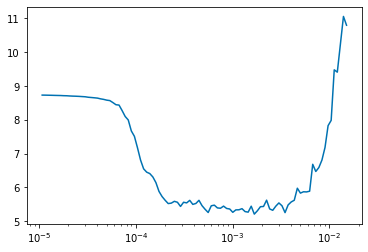

In [42]:
plt.semilogx(lr_list[:,0], lr_list[:,1])

In [43]:
optimal_lr = 1e-3


In [44]:
# Training loop
EVAL_INTERVAL = 100 # steps
PATIENCE = 10 # eval steps
train_losses_list = []
val_losses_list = []
train_bleu_list = []
val_bleu_list = []

epochs_since_last_val_best = 0

def train(model, num_epochs, lr = 1e-4):
    gc.collect()
    torch.cuda.empty_cache()

    min_valid_loss_until_now = 10**14
    min_train_loss_until_now = 10**14
    
    max_valid_bleu_until_now = 0
    epochs_since_last_val_best = 0
    
    nStep = 0
    
    try:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                                        steps_per_epoch=len(dataloader_train), 
                                                        epochs=num_epochs, 
                                                        cycle_momentum=True, 
                                                        anneal_strategy = 'linear', 
                                                        three_phase=True, 
                                                        pct_start=0.4,
                                                        div_factor=10.0,
                                                        final_div_factor = 1000.0
                                                        )
        for epoch in tqdm(range(num_epochs), desc= 'Epoch'):
            
            start = time.time()
            model.train()
                
            hidden = None

            loss_accumulated = 0
            for batch, a in tqdm(enumerate(dataloader_train), total=len(dataloader_train)):

                inputs = a[0]
                targets = a[1]
                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero gradients
                optimizer.zero_grad()

                # compute predictions
                pred,_  = model(inputs, targets)
                
                # compute loss
                loss = loss_function(pred.view(-1,pred.shape[-1]), targets.long().view(-1))

                # compute gradients
                loss.backward()

                # clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                # torch.nn.utils.clip_grad_value_(model.parameters(), CLIP_VAL)

                # update params
                optimizer.step()

                # lr scheduler
                scheduler.step()

                # logging
                writer.add_scalar("Loss_train_step", loss.item(), nStep)
                
                # log histograms of model params
#                 if (nStep)%200 ==0:
#                     for name,param in model.named_parameters():
#                         writer.add_histogram(name, param, -1)
#                         writer.add_histogram(name+'_log', torch.log(torch.abs(param)), -1)

                if (nStep%EVAL_INTERVAL == 0 ) :
                    loss_val, bleu_score_val = eval(dataloader_valid)
                    loss_train, bleu_score_train = eval(dataloader_train_e)
                    
                    print(f'nStep: {nStep}, Val_loss: {loss_val: .2f},Train_loss: {loss_train: .2f}, Val_bleu: {bleu_score_val}, Train_bleu: {bleu_score_train}')
                
                    writer.add_scalar('loss_val', loss_val,nStep)
                    writer.add_scalar('loss_train', loss_train, nStep)
                    writer.add_scalar('bleu_score_val', bleu_score_val, nStep)
                    writer.add_scalar('bleu_score_train', bleu_score_train, nStep)
                    
                    train_losses_list.append(loss_train)
                    val_losses_list.append(loss_val)
                    train_bleu_list.append(bleu_score_train)
                    val_bleu_list.append(bleu_score_val)

#                     if min_valid_loss_until_now > loss_val:
#                         min_valid_loss_until_now = loss_val

                    if max_valid_bleu_until_now <= bleu_score_val:
                        max_valid_bleu_until_now = bleu_score_val
                        torch.save({'epoch': epoch,
                                        'model_state_dict': model.state_dict(),
                                        'optimizer_state_dict': optimizer.state_dict(),
                                        'losses_list': losses_list,
                                        },  'Best_Valid_NMT_Attention.pt')

                        epochs_since_last_val_best = 0
                    else:
                        epochs_since_last_val_best += 1
                    
                nStep +=1

                # loss
                loss_accumulated += loss.item()


        # Do these per epoch
            loss_accumulated = loss_accumulated/len(dataloader_train)
            losses_list.append(loss_accumulated)

#             writer.add_scalar("Loss_train", loss_accumulated, epoch)            
            
            # Early stopping
            if epochs_since_last_val_best >= PATIENCE:
                print("Early stopping triggered!")
                break
            
            elapsed = time.time() - start

#             print(f'Epoch {epoch} done in {elapsed/60: .2f} minutes. Train_loss: {loss_accumulated: .2f}, Val_loss: {loss_val: .2f}, Val_bleu: {bleu_score_val}')
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses_list': losses_list,
            },  f'NMT_Attention_{epoch+1}_epochs.pt')
        
        print("Training finished. Training loss: " + str(loss_accumulated) )
        writer.flush()
        
        
    except KeyboardInterrupt:
        print("Keyboard interrupt detected")
        
    return model



In [45]:
# %tensorboard --logdir runs_NMT

In [46]:
writer = SummaryWriter(log_dir='TensorBoardLogs/NMT')

model = Seq2Seq(VOCAB_SIZE_SRC, VOCAB_SIZE_TRG, EMBEDDING_SIZE,NUM_HIDDEN_UNITS, NUM_RNN_LAYERS_ENC, NUM_RNN_LAYERS_DEC, DROPOUT_FRACTION,teacher_forcing_fraction=TEACHER_FORCING_FRACTION)
model = model.to('cuda')

model = train(model, num_epochs = 20, lr=optimal_lr) 

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 0, Val_loss:  8.72,Train_loss:  8.72, Val_bleu: 0.0, Train_bleu: 0.0
nStep: 100, Val_loss:  5.08,Train_loss:  5.13, Val_bleu: 0.0, Train_bleu: 0.0
nStep: 200, Val_loss:  4.94,Train_loss:  4.97, Val_bleu: 0.013791302219033241, Train_bleu: 0.013164459727704525


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 300, Val_loss:  4.92,Train_loss:  4.98, Val_bleu: 0.014960084110498428, Train_bleu: 0.013173973187804222
nStep: 400, Val_loss:  5.09,Train_loss:  5.19, Val_bleu: 0.013227307237684727, Train_bleu: 0.012173968367278576


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 500, Val_loss:  4.89,Train_loss:  4.97, Val_bleu: 0.02028031274676323, Train_bleu: 0.019852733239531517
nStep: 600, Val_loss:  5.25,Train_loss:  5.30, Val_bleu: 0.0299516711384058, Train_bleu: 0.02772192284464836


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 700, Val_loss:  4.93,Train_loss:  4.91, Val_bleu: 0.028317661955952644, Train_bleu: 0.02799162268638611
nStep: 800, Val_loss:  4.98,Train_loss:  5.02, Val_bleu: 0.03971114754676819, Train_bleu: 0.03864085301756859
nStep: 900, Val_loss:  4.80,Train_loss:  4.82, Val_bleu: 0.05070808529853821, Train_bleu: 0.04947058856487274


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 1000, Val_loss:  4.81,Train_loss:  4.83, Val_bleu: 0.07157367467880249, Train_bleu: 0.07062523812055588
nStep: 1100, Val_loss:  4.62,Train_loss:  4.63, Val_bleu: 0.08714306354522705, Train_bleu: 0.08803074061870575


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 1200, Val_loss:  4.46,Train_loss:  4.47, Val_bleu: 0.1008714959025383, Train_bleu: 0.10021279752254486
nStep: 1300, Val_loss:  4.44,Train_loss:  4.42, Val_bleu: 0.11828838288784027, Train_bleu: 0.11575216799974442


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 1400, Val_loss:  4.45,Train_loss:  4.36, Val_bleu: 0.12651483714580536, Train_bleu: 0.1307094246149063
nStep: 1500, Val_loss:  4.41,Train_loss:  4.28, Val_bleu: 0.1389191895723343, Train_bleu: 0.1386955976486206


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 1600, Val_loss:  4.28,Train_loss:  4.16, Val_bleu: 0.1420077383518219, Train_bleu: 0.1465921849012375
nStep: 1700, Val_loss:  4.37,Train_loss:  4.14, Val_bleu: 0.14492909610271454, Train_bleu: 0.15911252796649933
nStep: 1800, Val_loss:  4.37,Train_loss:  4.14, Val_bleu: 0.14690545201301575, Train_bleu: 0.15782004594802856


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 1900, Val_loss:  4.36,Train_loss:  4.03, Val_bleu: 0.15053687989711761, Train_bleu: 0.17257657647132874
nStep: 2000, Val_loss:  4.37,Train_loss:  3.91, Val_bleu: 0.1557733565568924, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 2100, Val_loss:  4.43,Train_loss:  3.90, Val_bleu: 0.1627618968486786, Train_bleu: 0.19447718560695648
nStep: 2200, Val_loss:  4.42,Train_loss:  3.72, Val_bleu: 0.16500236093997955, Train_bleu: 0.20130710303783417


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 2300, Val_loss:  4.33,Train_loss:  3.63, Val_bleu: 0.16826337575912476, Train_bleu: 0.0
nStep: 2400, Val_loss:  4.46,Train_loss:  3.57, Val_bleu: 0.16817820072174072, Train_bleu: 0.2211296707391739


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 2500, Val_loss:  4.56,Train_loss:  3.54, Val_bleu: 0.16864018142223358, Train_bleu: 0.23049509525299072
nStep: 2600, Val_loss:  4.60,Train_loss:  3.37, Val_bleu: 0.16232861578464508, Train_bleu: 0.0
nStep: 2700, Val_loss:  4.54,Train_loss:  3.28, Val_bleu: 0.17105674743652344, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 2800, Val_loss:  4.69,Train_loss:  3.24, Val_bleu: 0.17008249461650848, Train_bleu: 0.26603972911834717
nStep: 2900, Val_loss:  4.72,Train_loss:  3.07, Val_bleu: 0.1692851483821869, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 3000, Val_loss:  4.87,Train_loss:  3.03, Val_bleu: 0.17294210195541382, Train_bleu: 0.0
nStep: 3100, Val_loss:  4.77,Train_loss:  2.89, Val_bleu: 0.1691948026418686, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 3200, Val_loss:  4.89,Train_loss:  2.78, Val_bleu: 0.16244803369045258, Train_bleu: 0.0
nStep: 3300, Val_loss:  4.94,Train_loss:  2.61, Val_bleu: 0.16344337165355682, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 3400, Val_loss:  5.02,Train_loss:  2.55, Val_bleu: 0.1682358682155609, Train_bleu: 0.0
nStep: 3500, Val_loss:  5.05,Train_loss:  2.48, Val_bleu: 0.18049626052379608, Train_bleu: 0.0
nStep: 3600, Val_loss:  5.04,Train_loss:  2.41, Val_bleu: 0.1760161966085434, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 3700, Val_loss:  5.20,Train_loss:  2.35, Val_bleu: 0.17426688969135284, Train_bleu: 0.0
nStep: 3800, Val_loss:  5.21,Train_loss:  2.35, Val_bleu: 0.1742597222328186, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 3900, Val_loss:  5.27,Train_loss:  2.30, Val_bleu: 0.16747184097766876, Train_bleu: 0.0
nStep: 4000, Val_loss:  5.23,Train_loss:  2.30, Val_bleu: 0.17170438170433044, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 4100, Val_loss:  5.32,Train_loss:  2.25, Val_bleu: 0.17004269361495972, Train_bleu: 0.0
nStep: 4200, Val_loss:  5.36,Train_loss:  2.25, Val_bleu: 0.16986851394176483, Train_bleu: 0.0


  0%|          | 0/226 [00:00<?, ?it/s]

nStep: 4300, Val_loss:  5.35,Train_loss:  2.21, Val_bleu: 0.17224228382110596, Train_bleu: 0.0
nStep: 4400, Val_loss:  5.34,Train_loss:  2.21, Val_bleu: 0.1726248562335968, Train_bleu: 0.0
nStep: 4500, Val_loss:  5.34,Train_loss:  2.21, Val_bleu: 0.17457802593708038, Train_bleu: 0.0
Early stopping triggered!
Training finished. Training loss: 0.36522171250750535


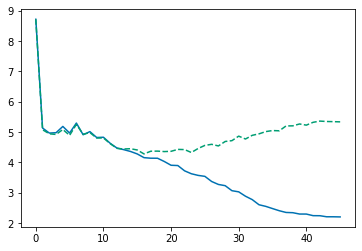

In [47]:
plt.plot(train_losses_list)
plt.plot(val_losses_list, '--')

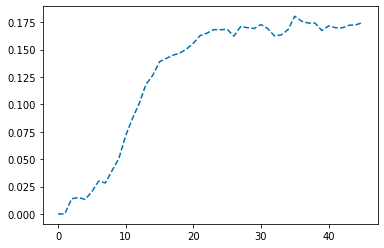

In [48]:
plt.plot(val_bleu_list, '--')

In [49]:
model.load_state_dict(torch.load('Best_Valid_NMT_Attention.pt')['model_state_dict'])
model = model.to('cpu')
model.eval()

Seq2Seq(
  (encoder): EncoderBlock(
    (embedding): Embedding(8014, 512, padding_idx=0, scale_grad_by_freq=True)
    (rnn): GRU(512, 512, num_layers=4, batch_first=True)
  )
  (decoder): DecoderAttentionBlock(
    (embedding): Embedding(6191, 512, padding_idx=0, scale_grad_by_freq=True)
    (attention): AttentionBlock(
      (linear): Linear(in_features=512, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
    )
    (tanh): Tanh()
    (rnn): GRU(512, 512, num_layers=4, batch_first=True)
    (linear): Linear(in_features=1024, out_features=1024, bias=False)
    (fc): Linear(in_features=1024, out_features=6191, bias=True)
    (lsf): LogSoftmax(dim=-1)
  )
)

In [50]:
# from googletrans import Translator
# translator = Translator()

ind: 639 

Source: 
Ein Mann mit einem schwarzen Hut macht ein Foto auf einer belebten Straße .

Original Translation: 
A man wearing a black hat taking a photo in a busy street .

Translation: 
A man in a black hat is taking a picture on a busy street .
-----------------------------------------------------
ind: 22 

Source: 
Eine Gruppe von Leuten , die auf Stühlen sitzen .

Original Translation: 
A group of people are sitting in chairs .

Translation: 
A group of people sitting on chairs .
-----------------------------------------------------
ind: 821 

Source: 
Ein Junge und sein jüngerer Bruder spielen gemeinsam auf einem Spielplatz .

Original Translation: 
A boy and his younger brother playing together at the playground .

Translation: 
A boy and his younger brother playing together on a playground .
-----------------------------------------------------
ind: 696 

Source: 
Eine Frau isst an einem schönen Tag auf dem Gras .

Original Translation: 
A woman eating in the grass on a 

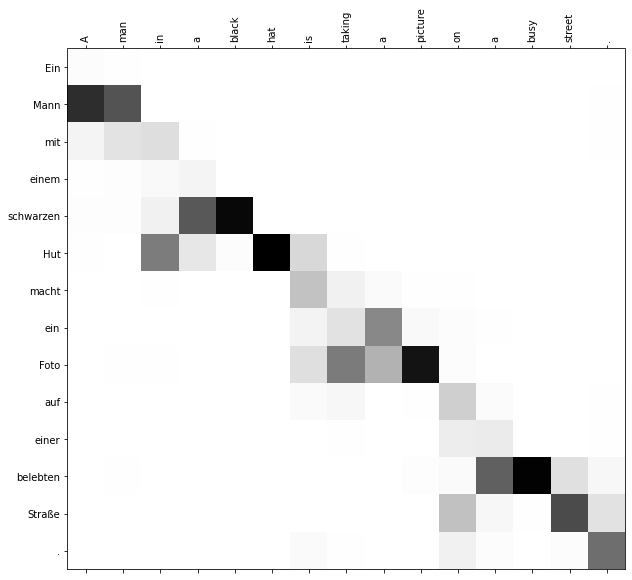

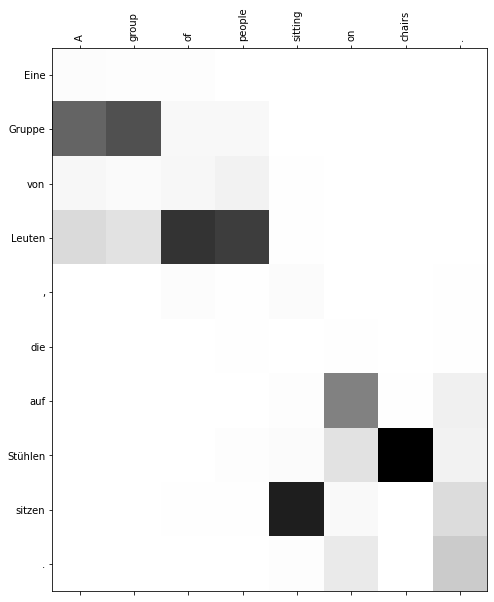

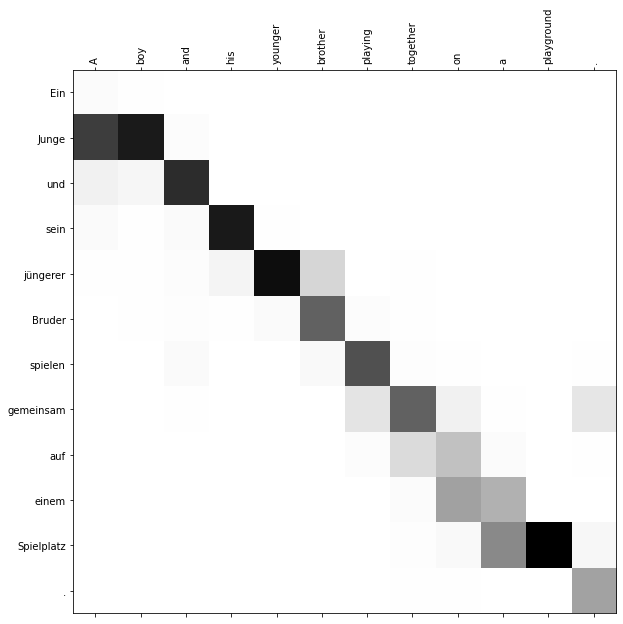

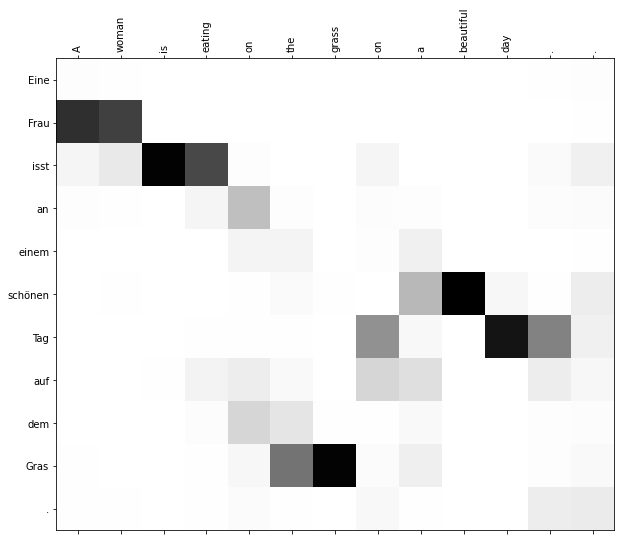

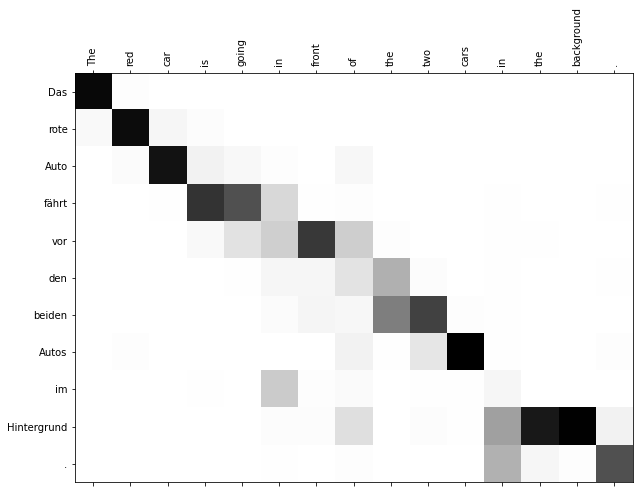

In [51]:
eos_indx = 3
bos_indx = 2
inputs, targets = next(iter(dataloader_test))
for _ in range(5):
    
    ind = torch.randint(low=0, high=len(inputs), size=(1,)).item()
    print(f'ind: {ind} \n')
    src = ' '.join([v_s[token]  for token in inputs[ind,:].tolist() if token not in [pad_indx,bos_indx, eos_indx]])
    print('Source: \n'+ src)
    print('\nOriginal Translation: \n'+ ' '.join([v_t[token] for token in targets[ind,:].tolist() if token not in [pad_indx,bos_indx, eos_indx]]))
    outp,av = model(inputs[ind].unsqueeze(0), targets[ind].unsqueeze(0), teacher_forcing_fraction =0)
    pred= torch.argmax(  outp , dim=2).squeeze(0).tolist()
    pred_t = ' '.join([v_t[token] for token in pred if token not in [pad_indx,bos_indx, eos_indx]])
    print('\nTranslation: \n'+pred_t )
    # print('\nTranslation: \n'+ ' '.join([v_t[token] for token in model.translate(inputs[ind].unsqueeze(0),32).argmax(dim=2).squeeze().tolist()]))
    fig, ax = plt.subplots(figsize=[10, 10])
    ax.matshow(av.squeeze(0)[0:len(src.split()),0:len(pred_t.split())].detach().numpy(), cmap=plt.get_cmap('Greys'))
    xlabels = src.split()
    # xlabels= [token+': ' +translator.translate(token).text for token in xlabels]
    ylabels = pred_t.split()
    x=ax.set_yticks(np.arange(len(src.split())))
    x=ax.set_yticklabels(xlabels)
    y=ax.set_xticks(np.arange(len(pred_t.split())))
    y=ax.set_xticklabels(ylabels,rotation=90)
    print('-----------------------------------------------------')

We haven't even considered beam search to generete translation; just a simple greedy seach translation. The results are still pretty good!